In [1]:
import numpy as np
import matplotlib.pyplot as plt

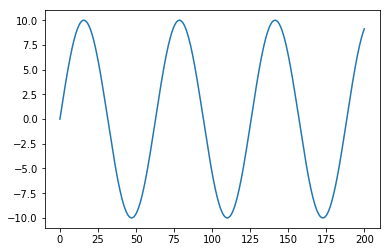

In [124]:
A = 10
ω = 1 / 10
N_POINTS = 1000
T_MAX = 200

def real_movement(t):
    return A * np.sin(ω * t), ω * A * np.cos(ω * t), -ω ** 2 * A * np.sin(ω * t)

t = np.linspace(0, T_MAX, N_POINTS)
plt.plot(t, real_movement(t)[0])

In [156]:
RNG = np.random.RandomState(42)
t_mask = RNG.uniform(size=N_POINTS) < 0.1
# t_index = np.cumsum(t_mask)[1:]
# t_observed = np.linspace(0, 60, N_POINTS)[t_mask]
# x, v, a = real_movement(t_observed)
# x_observed += RNG.normal(size=t_observed.shape) * 1.0
# plt.plot(t_observed, x)

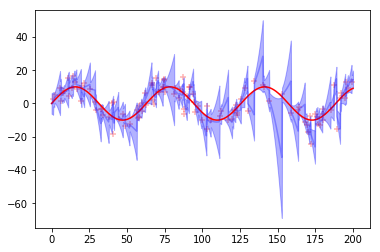

In [204]:
state_mean = np.zeros(shape=(N_POINTS, 3))
state_cov  = np.zeros(shape=(N_POINTS, 3, 3))

S0_0 = np.array([[A, 0, 0], [0, ω * A, 0], [0, 0, ω**2 * A]])
S0_1 = np.array([[ω * A * T_MAX / N_POINTS, 0, 0], [0, ω**2 * A * T_MAX / N_POINTS, 0], [0, 0, ω**3 * A * T_MAX / N_POINTS]])

state_cov[0] = S0_0

x_observed = real_movement(t)[0] + RNG.normal(size=N_POINTS) * 5

for i in range(1, N_POINTS):
    dt = t[i] - t[i - 1]
    X = state_mean[i - 1].reshape(3,1)
    S = state_cov[i - 1]
    
    T = np.array([
        [1, dt, dt**2], # x* = x + v dt + a dt ** 2
        [0,  1,    dt], # v* = v + a dt
        [0,  0,     1]  # a* = a
    ])
    Xp = np.einsum('ij,jk', T, X)
    Sp = np.einsum('ij,jk,lk', T, S, T) + S0_1
    
    if t_mask[i]:
        H = np.array([
            [1, 0, 0]
        ])
        Xpo = np.einsum('ij,jk', H, Xp)
        Spo = np.einsum('ij,jk,lk', H, Sp, H)

        Xro = x_observed[i].reshape((1,1))
        Sro = np.array([[5.0]])

        K = np.einsum('ij,kj,kl', Sp, H, np.linalg.inv(Spo + Sro))
        # print(K.shape, Xpo.shape, Xro.shape)
        Xn = Xp + np.einsum('ij,jk', K, Xro - Xpo)
        Sn = Sp - np.einsum('ij,jk,kl', K, H, Sp)

    #     print(Xp)
    #     print(np.einsum('ij,jk', K, Xro - Xpo))
    #     print(Xn)
        state_mean[i] = Xn.reshape(3)
        state_cov[i] = Sn.reshape(3, 3)
    else:
        state_mean[i] = Xp.reshape(3)
        state_cov[i] = Sp.reshape(3, 3)
    
    # print(state_cov[i])

# plt.xlim([0, 30])
plt.plot(t, real_movement(t)[0], color='red')
plt.scatter(t[t_mask], x_observed[t_mask], color='red', alpha=0.3, marker='+')
plt.plot(t, state_mean[:,0], color='blue', alpha=0.3)
plt.fill_between(
    t, 
    state_mean[:,0] - np.sqrt(state_cov[:,0,0]) * 1.96, 
    state_mean[:,0] + np.sqrt(state_cov[:,0,0]) * 1.96,
    alpha=0.3, color='blue')
plt.show()

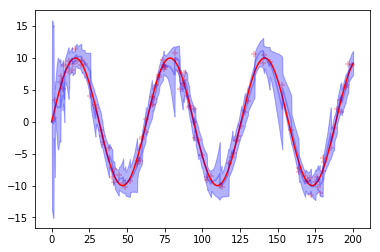

In [266]:
N_PARTICLES = 1000
particles = np.zeros(shape=(N_POINTS, 3, N_PARTICLES))

# State is (A, phi, omega)
# Update is 
#   phi = (phi + omega dt) % 2 π
# Observation is
#   x = A sin(phi)

particles[0,0,:] = RNG.normal(size=N_PARTICLES) * A
particles[0,1,:] = RNG.uniform(size=N_PARTICLES) * 2 * np.pi
particles[0,2,:] = RNG.normal(size=N_PARTICLES)

x_observed = real_movement(t)[0] + RNG.normal(size=N_POINTS) * 1
x_predicted = np.zeros(N_POINTS)
x_uq = np.zeros(N_POINTS)
x_lq = np.zeros(N_POINTS)

for i in range(1, N_POINTS):
    dt = t[i] - t[i - 1]
    S = particles[i - 1]
    
    S[1,:] = (S[1,:] + S[2,:] * dt) % (2 * np.pi)
    
    X = S[0,:] * np.sin(S[1,:])
    W = np.ones(N_PARTICLES)
    
    x_predicted[i] = np.mean(X)
    x_uq[i] = np.quantile(X, 0.975)
    x_lq[i] = np.quantile(X, 0.025)
    
    # print(x_predicted[i], x_uq[i], x_lq[i])
    
    if t_mask[i]:
        X_real = x_observed[i]
        X_std = 1
        W *= (1 / np.sqrt(2 * np.pi * X_std**2)) * np.exp(-(X_real - X)**2 / (2 * X_std ** 2))
        W = W / np.sum(W)
        I = RNG.choice(N_PARTICLES, size=N_PARTICLES, p=W)
        S = S[:,I]
        
        S[0,:] += RNG.normal(size=(N_PARTICLES)) * 0.5
        S[1,:] += RNG.normal(size=(N_PARTICLES)) * 2 * np.pi / 100
        S[2,:] += RNG.normal(size=(N_PARTICLES)) * 0.01
        particles[i] = S
    else:
        particles[i] = S

# plt.xlim([0, 30])
plt.plot(t, real_movement(t)[0], color='red')
plt.scatter(t[t_mask], x_observed[t_mask], color='red', alpha=0.3, marker='+')
plt.plot(t, x_predicted, color='blue', alpha=0.3)
plt.fill_between(
    t, 
    x_uq, 
    x_lq,
    alpha=0.3, color='blue')
plt.show()

In [170]:
import subprocess
from collections import namedtuple

In [202]:
Continue = object()
Kill = object()

def stream(n=1000):
    def parse_event(line):
        line = line.strip()
        
        sp = line.index(' ')
        name = line[:sp]
        line = line[sp+1:]
        
        sp = line.index(' ')
        ts = int(line[:sp])
        line = line[sp+1:]
        
        assert line[0] == '['
        assert line[-1] == ']'
        
        line = line[1:-1]
        args = [x.strip() for x in line.split(',')]
        return (name, ts, args)
    
    args = ["bash", "-c", "~/Library/Android/sdk/platform-tools/adb logcat | grep Epistle"]
    with subprocess.Popen(args, stdout=subprocess.PIPE) as proc:
        try:
            for i in range(n):
                line = proc.stdout.readline()
                tag = b'Epistle : '
                index = line.index(tag)
                if index != -1:
                    line = line[index + len(tag):].decode('utf-8').strip()
                    ev = parse_event(line)
                    yield ev
        finally:
            proc.kill()

RAW_DATA = list(stream(100000))

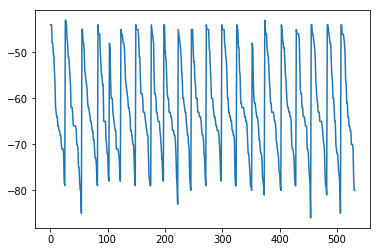

In [203]:
DATA = [[float(v) for v in x[2][1:]] for x in RAW_DATA if x[0] == 'WIFI']
DATA = np.array(DATA)
plt.plot(DATA[:, 0])

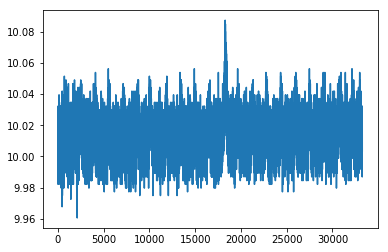

In [273]:
DATA = [[float(v) for v in x[2]] for x in RAW_DATA if x[0] == 'ACC']
DATA = np.array(DATA)
plt.plot(DATA[:, 2])